In [195]:
import numpy as np
import matplotlib

# The lines below are specific to the notebook format
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 6)
plt = matplotlib.pyplot
from mpl_toolkits.mplot3d import Axes3D

In [196]:
def gen_data(X, Y):
    
    ys = []
    for x0, x1 in zip(X,Y):
#         x0, x1 = x[0], x[1]
        y = x0 * np.sin(x0*10)
        y = x1 * np.sin(x0*10)
        y += 1
#         y += np.random.uniform(0, 0.1)
        ys.append(y)
    return np.array(ys)

In [272]:
# generate some fake data
x = np.linspace(0, 1, 20)
# x = x[::2]
X, Y = np.meshgrid(x, x)

X = X.ravel()
Y = Y.ravel()

z = gen_data(X, Y)

XY = np.column_stack([[X, Y]]).T



In [273]:
z.shape

(400,)

In [274]:
X.shape

(400,)

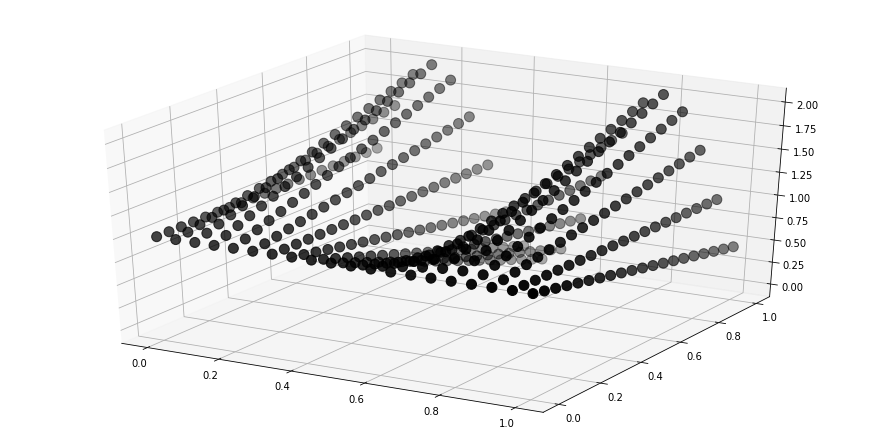

In [275]:
fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(XY[:,0], XY[:,1], z, s=100, c='k')

In [276]:
import george
george.__version__

'0.3.1'

In [277]:
XY.shape

(400, 2)

In [278]:
z.shape

(400,)

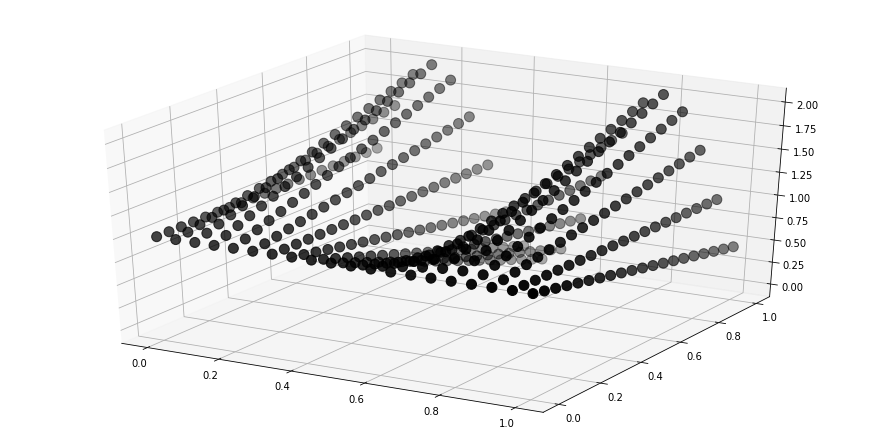

In [279]:
fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(XY[:,0], XY[:,1], z, s=100, c='k')

In [284]:
zerr = np.zeros_like(z) + 1e-2

In [285]:
from george import kernels

kernel = np.var(z) * kernels.ExpSquaredKernel(0.5, ndim=2, axes=0)
kernel *= kernels.ExpSquaredKernel(0.5, ndim=2, axes=1)

In [286]:
gp = george.GP(kernel)
gp.compute(XY, zerr)

In [287]:
gp.get_parameter_dict()

OrderedDict([('kernel:k1:k1:log_constant', -2.576071470531277),
             ('kernel:k1:k2:metric:log_M_0_0', -0.6931471805599453),
             ('kernel:k2:metric:log_M_0_0', -0.6931471805599453)])

In [288]:
%%time
import scipy.optimize as op

# Define the objective function (negative log-likelihood in this case).
def nll(p):
    gp.set_parameter_vector(p)
    ll = gp.log_likelihood(z, quiet=True)
    return -ll if np.isfinite(ll) else 1e25

# And the gradient of the objective function.
def grad_nll(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(z, quiet=True)

# You need to compute the GP once before starting the optimization.
gp.compute(XY, zerr)

# Print the initial ln-likelihood.
print(gp.log_likelihood(z))

# Run the optimization routine.
p0 = gp.get_parameter_vector()
results = op.minimize(nll, p0, jac=grad_nll, method="L-BFGS-B")

# Update the kernel and print the final log-likelihood.
gp.set_parameter_vector(results.x)
print(gp.log_likelihood(z))

-64221.827950050254
1352.4489337874345
CPU times: user 1.85 s, sys: 16.3 ms, total: 1.86 s
Wall time: 473 ms


In [289]:
gp.get_parameter_dict()

OrderedDict([('kernel:k1:k1:log_constant', 1.7447786326696197),
             ('kernel:k1:k2:metric:log_M_0_0', -2.844525073430216),
             ('kernel:k2:metric:log_M_0_0', 2.5897000033864073)])

In [290]:
# pred, pred_var = gp.predict(z, np.array([[0,0]]))
pred, pred_var = gp.predict(z, XY)

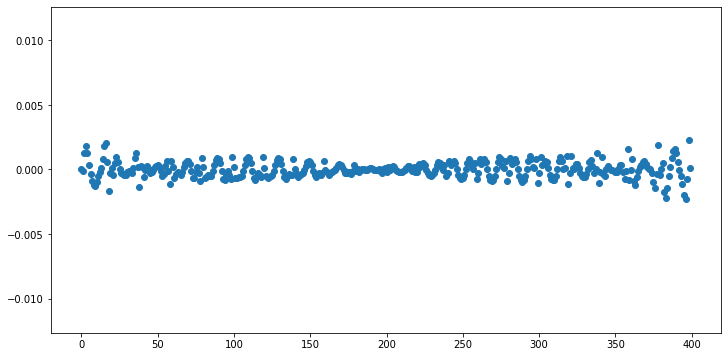

In [291]:
plt.figure()
plt.scatter(range(len(z)), pred - z)

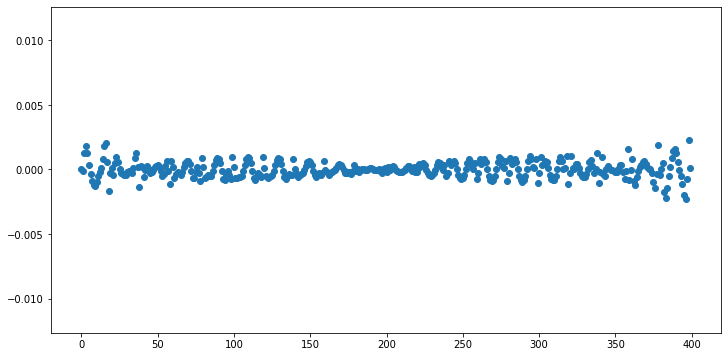

In [292]:
plt.figure()
plt.scatter(range(len(z)), pred - z)

In [293]:
# generate some fake data
xval = np.linspace(0, 1, 40)
Xval, Yval = np.meshgrid(xval, xval)
# x = x[::6]

Xval = Xval.ravel()
Yval = Yval.ravel()

zval = gen_data(Xval, Yval)

XYval = np.column_stack([[Xval, Yval]]).T


In [294]:
zval.shape

(1600,)

In [295]:
XYval.shape

(1600, 2)

In [296]:
pred_val, pred_var_val = gp.predict(z, XYval)

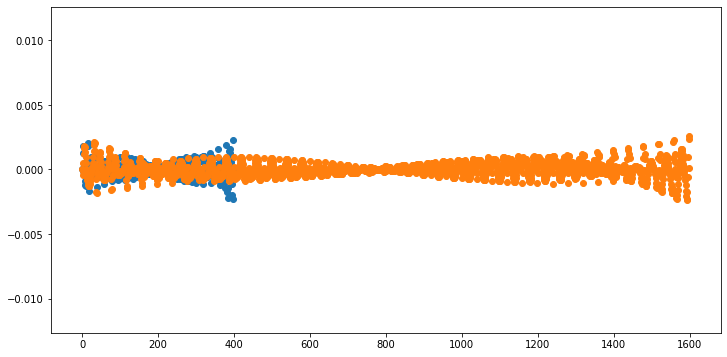

In [297]:
plt.figure()
plt.scatter(range(len(z)), pred - z)
plt.scatter(range(len(zval)), pred_val - zval)

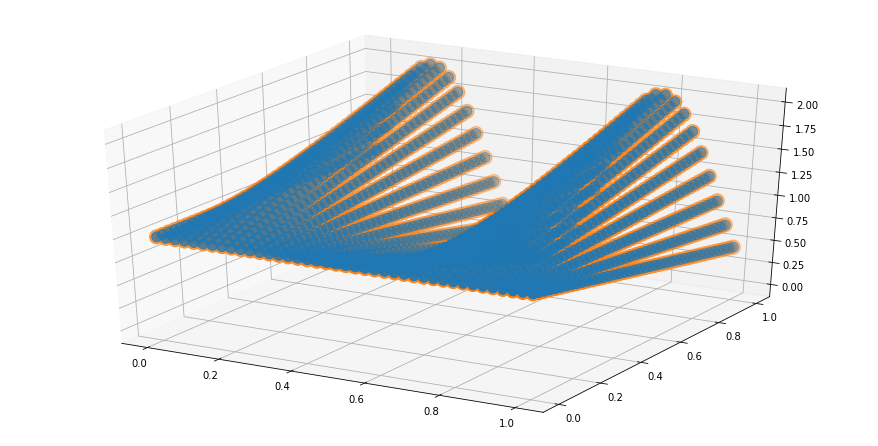

In [301]:
fig = plt.figure()
ax = Axes3D(fig)


ax.scatter(XYval[:,0], XYval[:,1], zval, s=100, c='C0')
ax.scatter(XYval[:,0], XYval[:,1], pred_val, s=200, c='C1')
# ax.scatter(XY[:,0], XY[:,1], z, s=300, c='k')